# Preprocessing - Removing Random Noise

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


In [ ]:
header_df = pd.read_csv('./raw_data/train_data.csv', nrows=0).columns.tolist()


print(f"The number of Columns in DataFrame {len(header_df)}")




The number of Columns in DataFrame 190


In [16]:
# Geting the First 10 columns to investigate data type

df = pd.read_csv('./raw_data/train_data.csv', usecols=header_df[0:3])
df.head(2)

,customer_ID,S_2,P_2
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665


<Figure size 1200x800 with 0 Axes>

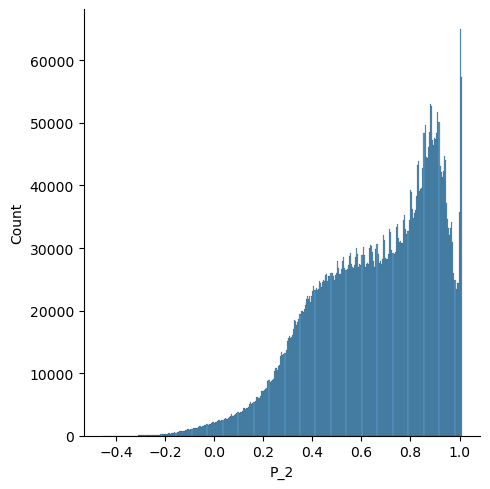

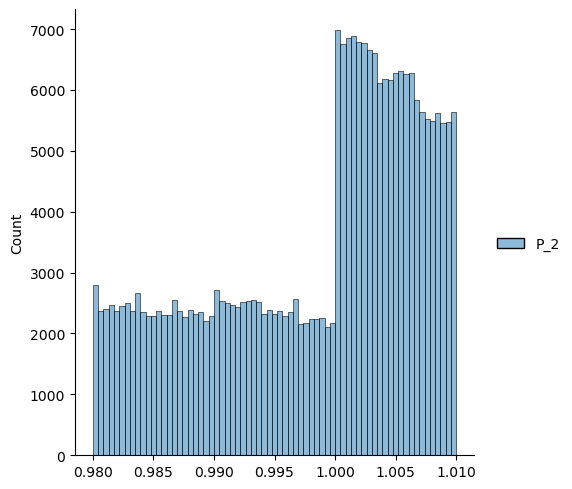

In [17]:
plt.figure(figsize=(12,8))
sns.displot(df['P_2'])
sns.displot(df.loc[df['P_2'] > 0.98])
plt.show()


# Sample Solution by RADDAR 

Critiques of Solution 
- Lack of Statistical rigidity : the solution assumes that if range of value is between [1, 1.01] then just convert it to 1, rather then checking if distribution of value between [1, 1.1] follow uniform distribution


In [26]:
def floorify(x, lo):
    """example: x in [0, 0.01] -> x := 0"""
    return lo if x <= lo+0.01 and x >= lo else x

def floorify_ones(x):
    """look around values [1,1.01] and determine if in proximity it's categorical. If yes - floorify"""    
    has_ones = len([t for t in x if t>=1 and t<=1.01])>0 
    no_proximity = len([t for t in x if t<1 and t>=0.99])==0 and len([t for t in x if t>1.01 and t<=1.02])==0
    if not no_proximity:
        return x
    if not has_ones:
        return x

    x = [floorify(t, 1.0) for t in x]
    return x

x = [1.001, 1.002, 12, 1]

p = floorify_ones(x)

print(p)


[1.0, 1.0, 12, 1.0]


# Solution One - Identity Testing 

*Notes used*:

6.889 Sublinear Time Algorithms
- Part 1: https://people.csail.mit.edu/ronitt/COURSE/F20/Handouts/scribe12-13.pdf
- Part 2: https://people.csail.mit.edu/ronitt/COURSE/S19/Handouts/scribe13.pdf 

CSE 522: Sublinear (and Streaming) Algorithms
- https://courses.cs.washington.edu/courses/cse522/14sp/lectures/lect07.pdf


*Overview*:

HARD! Don't Understand need to work on it!

# Solution Two - Kolomogov-Soltov test

This is my own solution to add more statistical rigore it
1. Find Values between given range 
2. Convert values into edf
3. Check KS test
4. Convert values if passes KS test


Currently only work for values between [1, 0.1] add more range!


<Figure size 300x300 with 0 Axes>

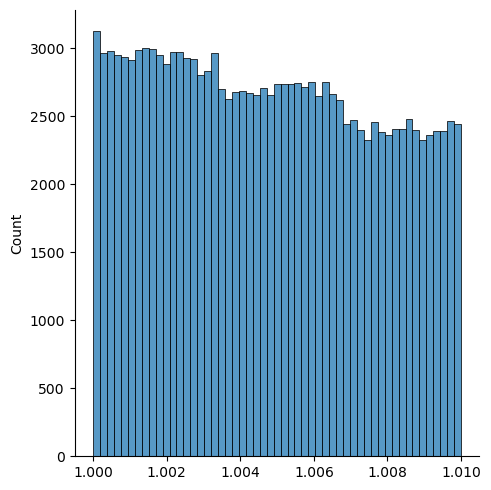

EDF computed successfully with length 100.


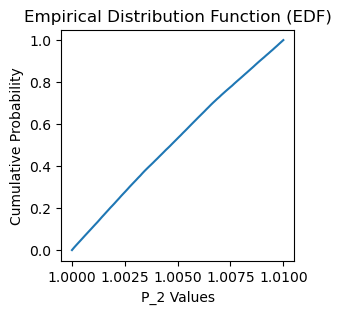

The given distribution is Uniform Distribution: True


In [45]:
import numpy as np 
import scipy 
from scipy import stats

def floorify(x, lo):
    """example: x in [0, 0.01] -> x := 0"""
    return lo if x <= lo+0.01 and x >= lo else x

# Flooring if required 
def floorify_ones(x):
    """look around values [1,1.01] and determine if in proximity it's categorical. If yes - floorify"""    
    has_ones = len([t for t in x if t>=1 and t<=1.01])>0 
    no_proximity = len([t for t in x if t<1 and t>=0.99])==0 and len([t for t in x if t>1.01 and t<=1.02])==0
    if not no_proximity:
        return x
    if not has_ones:
        return x

    x = [floorify(t, 1.0) for t in x]
    return x


# Computing EDF
def empirical_distribution_function(data):
    """
        data : 1d array of values wanting to find EDF
    """

    x0 = data.min()
    x1 = data.max()
    x = np.linspace(x0, x1, 100)

    if data.size == 0:
        ValueError("Data is empty. Cannot computre EDF")
    N = data.size

    y = np.zeros_like(x)

    for i, xx in enumerate(x):
        # looks through data to check current element count
        # create a percentage
        y[i] = np.sum(data <= xx) / N

    try:
        plt.figure(figsize=(3, 3))
        sns.lineplot(x=x, y=y)
        plt.title("Empirical Distribution Function (EDF)")
        plt.xlabel("P_2 Values")
        plt.ylabel("Cumulative Probability")
        plt.show()
    except Exception as e:
        print(f"Empirical Distribution Function failed: {e}")

    return x,y


def test_KS_test(x, y, distribution='uniform'):
    """
        x : array of domain 
        y : array of CDF values
    """
    uniform_distribution = False
    if y.size == 0:
        ValueError("This data is empty")
    
    p_value = stats.kstest(y, stats.uniform.cdf)[1]

    if p_value > 0.95:
        uniform_distribution = True

    return uniform_distribution


def check_if_ranged_values_is_uniform(data, col):

    """
        data : DataFrame
        col : Feature from DataFrmae 
    """

    # Get all values between [1, 1.01]
    try:
        # Find all values between 1 0.1 
        df_ranged = np.array([i for i in data[col] if i > 1.0 and i < 1.01])

        # Plot figure
        plt.figure(figsize=(3,3))
        sns.displot(df_ranged)
        plt.show()
    except:
        ValueError("Something Want wrong in finding values between")

    # Convert pdf to edf
    try:
        x, y = empirical_distribution_function(df_ranged)
    except Exception as e:
        print(f"Empirical Distribution Function failed: {e}")

    # Check if uniform distribution and implement if required
    try:
        check_uniform_distribution = test_KS_test(x, y, distribution='uniform')
        print(f"The given distribution is Uniform Distribution: {check_uniform_distribution}")
        
        if check_uniform_distribution:
            data[col] = floorify_ones(data[col])
    except Exception as e:
        print(f"Something went wrong with Uniform KS test function {e}")